<a href="https://colab.research.google.com/github/FaridRash/IGNIS/blob/main/Notebooks/ML/Polynominal_RF_SNR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"In this notebook, I have calculated the SNR of the target and background over the wavelength range of 8–14 µm."

'in this notebook ive calculated the SNR of the target and background on wavelength range 8-14'

#Libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score


#Formulas

In [3]:
c1 = 3.7418e8
c2 = 1.4388e4
h = 6.626e-34
c = 3e8

In [4]:
def compute_gsd(H, f, p):
  return (H * p / f) **2

In [5]:
epsilon = 0.95
tau_0 = 0.89
eta = 0.7
t = 0.01
focal_length = 72.8 / 1000
pixel = 12e-6
F_number = 1.05
D = (focal_length / F_number)

lambda_range = np.arange(8, 14, 0.1)
delta_lambda = 0.1

In [6]:
def compute_wighted_snr(Tg,Tf, theta_deg, R, tau_a):
  # The area of the target and background
    Af = 10*10
    Agsd = compute_gsd(R, focal_length, pixel)
    Ag = Agsd - Af

    #Blackbody calculation
    cos_theta = np.cos(np.deg2rad(theta_deg))
    M_lambda_g = c1 / (lambda_range**5 * (np.exp(c2 / (lambda_range * Tg)) - 1))
    M_lambda_f = c1 / (lambda_range**5 * (np.exp(c2 / (lambda_range * Tf)) - 1))

    #Radiance calculation
    E_lambda_g = epsilon * M_lambda_g
    E_lambda_f = epsilon * M_lambda_f

    #Signal calculation
    S_lambda_g = ((D**2 * t * cos_theta * Ag) / (4 * R**2 * h * c)) * (lambda_range * E_lambda_g * tau_a * tau_0 * eta * delta_lambda)
    S_lambda_f = ((D**2 * t * cos_theta * Af) / (4 * R**2 * h * c)) * (lambda_range * E_lambda_f * tau_a * tau_0 * eta * delta_lambda)


    #Sum of S
    S_Ag = np.sum(S_lambda_g)
    S_Af = np.sum(S_lambda_f)

    #S' calculation
    S_prime_g = S_Ag / Ag
    S_prime_f = S_Af / Af
    S_prime = S_prime_f - S_prime_g

    #N' calculation
    N_prime = np.sqrt(S_prime_f + S_prime_g)

    #SNR' calculation
    SNR_prime = S_prime / N_prime


    #Spectral SNR Contribution per λ
    #S'_lambda calculation
    S_prime_lambda_g = S_lambda_g / Ag
    S_prime_lambda_f = S_lambda_f / Af

    #S'_lambda calculation
    S_prime_lambda = S_prime_lambda_f - S_prime_lambda_g

    #SNR'_lambda
    SNR_prime_lambda = S_prime_lambda / N_prime

    return SNR_prime, SNR_prime_lambda, S_prime, N_prime





#Dataset

In [7]:
Tf_range = np.arange(413.15, 434.15, 4.2)
Tg_range = np.arange(283.15, 374.15, 20)
R_range = np.arange(460000, 149999, -20665)
tau_a = np.arange(0.1, 0.6, .05)
theta_range = np.arange(0, 22, 2)
print(len(Tf_range) * len(Tg_range) * len(R_range) * len(tau_a) * len(theta_range))

44000


In [8]:
df = pd.DataFrame(columns=['Tg', 'Tf', 'theta', 'R', 'tau_a'])

In [9]:
data = []
for Tg in Tg_range:
    for R in R_range:
        for tau in tau_a:
            for theta in theta_range:
                for Tf in Tf_range:
                  # Compute weighted SNR
                  snr, snr_lambda, s_prime, n_prime = compute_wighted_snr(Tg, Tf, theta, R, tau)

                 # Append all features + result to the dataset
                  data.append({
                     'Tg': Tg,
                     'Tf': Tf,
                     'theta': theta,
                     'R': R,
                     'tau_a': tau,
                     "SNR'": snr,
                     "SNR_lambda": snr_lambda,
                     "S'": s_prime,
                     "N'": n_prime
                  })
df = pd.DataFrame(data)

In [10]:
df.columns

Index(['Tg', 'Tf', 'theta', 'R', 'tau_a', 'SNR'', 'SNR_lambda', 'S'', 'N''], dtype='object')

#Features

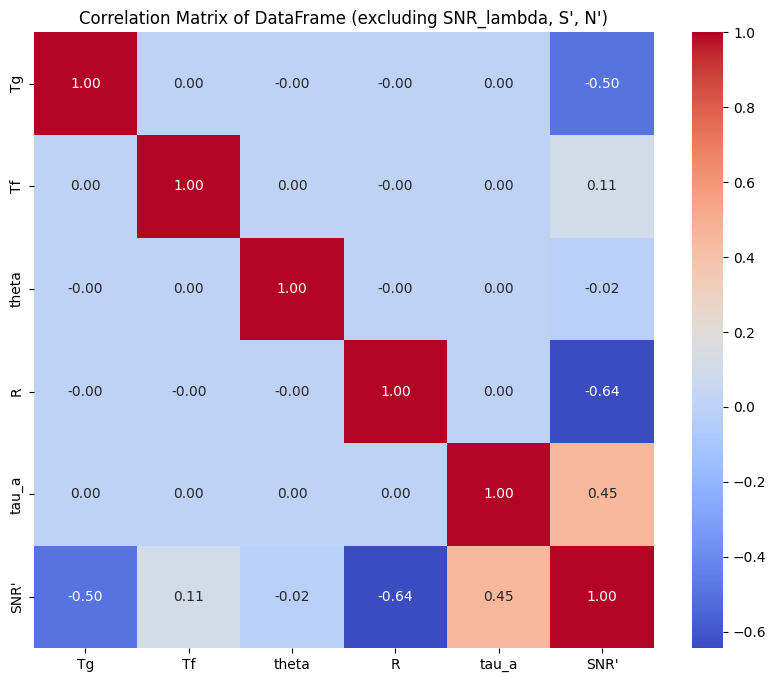

In [11]:
# Drop the specified columns
df_corr = df.drop(columns=["SNR_lambda", "S'", "N'"])

# Calculate the correlation matrix
correlation_matrix = df_corr.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of DataFrame (excluding SNR_lambda, S\', N\')')
plt.show()

In [12]:
X = ['Tg', 'Tf', 'theta', 'R', 'tau_a']
y = "SNR'"

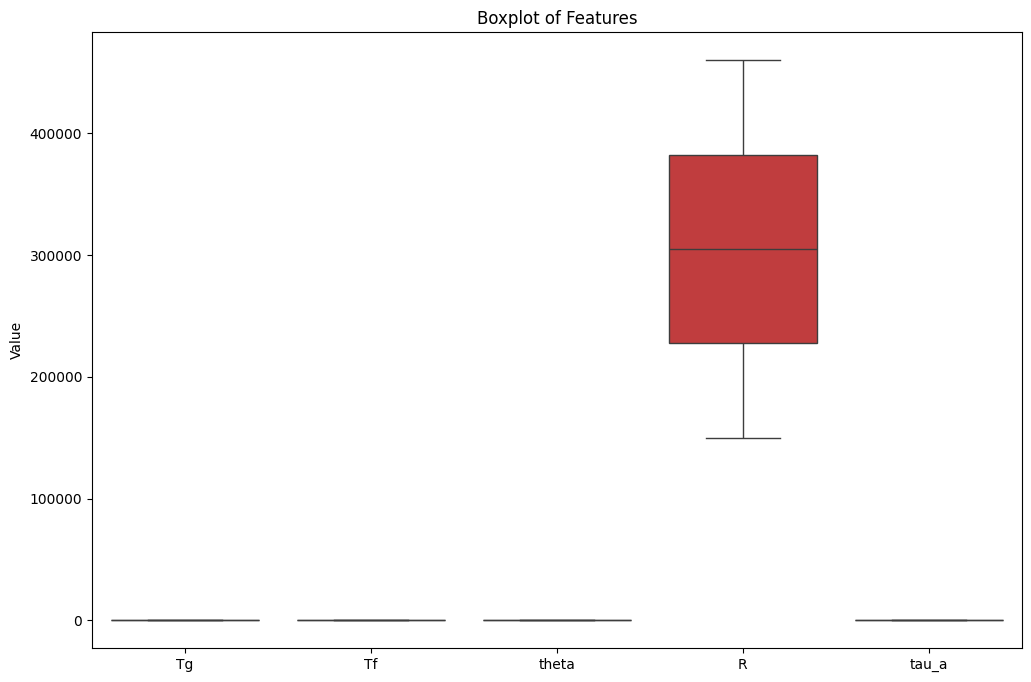

In [13]:
# prompt: plot X features with boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(data=df[X])
plt.title('Boxplot of Features')
plt.ylabel('Value')
plt.show()

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df[X], df[y], test_size=0.2, random_state=42)

In [15]:
len(X_test), len(X_train), len(y_test), len(y_train)

(8800, 35200, 8800, 35200)

Scaled Training Data:
         Tg        Tf     theta         R     tau_a
0 -0.709607 -0.707609  0.637805  1.411493  0.178942
1  1.413965 -1.414015  1.587270 -1.623155 -1.561622
2  1.413965 -0.001204 -0.311660  0.110930  0.527055
3  0.706108 -0.707609  0.954293 -1.189634  1.571393
4 -0.709607 -1.414015  0.637805  0.327690  0.875167

Scaled Test Data:
         Tg        Tf     theta         R     tau_a
0  0.706108  1.411606 -0.628148 -1.406394 -1.561622
1  0.706108 -0.707609 -0.944637  1.628253  0.875167
2 -1.417464 -1.414015  0.637805  0.110930  0.527055
3  1.413965 -1.414015  0.321316  0.110930  0.875167
4  1.413965  0.705201  0.954293  0.977972  0.527055


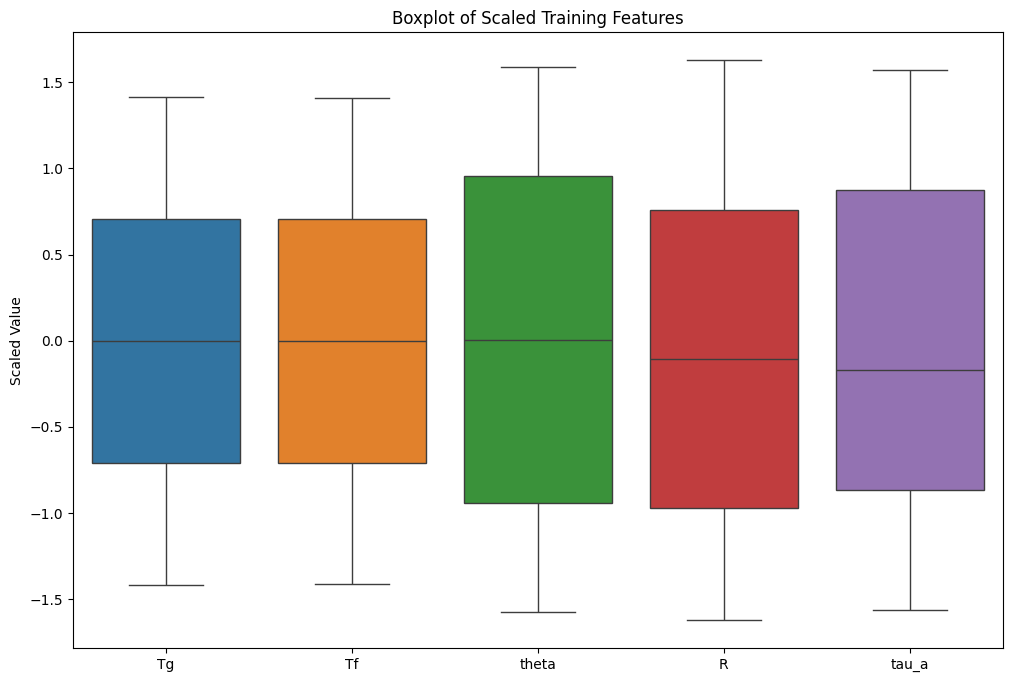

In [16]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to DataFrames (optional, but often useful)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Display the first few rows of the scaled dataframes to verify
print("Scaled Training Data:")
print(X_train_scaled_df.head())

print("\nScaled Test Data:")
print(X_test_scaled_df.head())

# You can also visualize the scaled data to see the effect
plt.figure(figsize=(12, 8))
sns.boxplot(data=X_train_scaled_df)
plt.title('Boxplot of Scaled Training Features')
plt.ylabel('Scaled Value')
plt.show()

#Linear Regression

In [17]:
# Initialize the Linear Regression model
model = LinearRegression()

# Train the model
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

# Display model coefficients
print("\nModel Coefficients:")
for feature, coef in zip(X_train.columns, model.coef_):
    print(f"{feature}: {coef:.4f}")
print(f"Intercept: {model.intercept_:.4f}")

Mean Squared Error: 9421022131.28
R-squared: 0.88

Model Coefficients:
Tg: -142238.0683
Tf: 31851.7119
theta: -5405.6224
R: -185257.2890
tau_a: 130150.3929
Intercept: 542412.3852


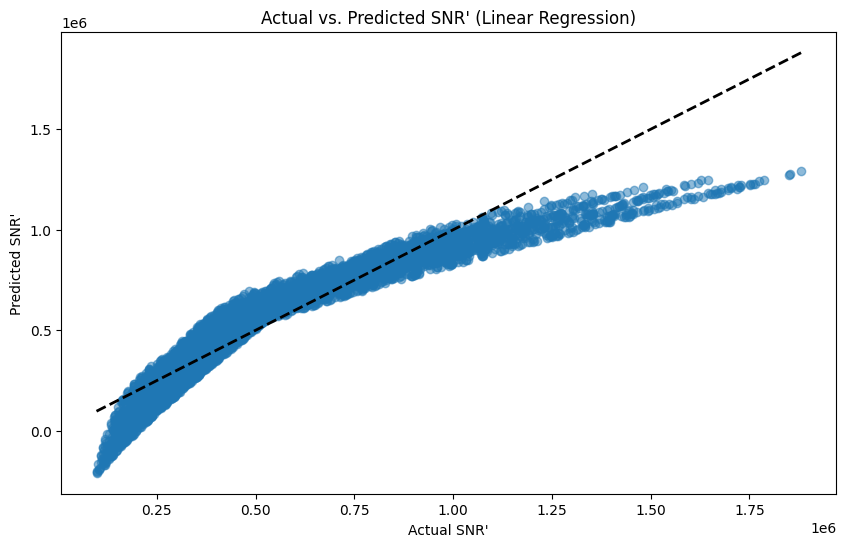

In [18]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual SNR'")
plt.ylabel("Predicted SNR'")
plt.title("Actual vs. Predicted SNR' (Linear Regression)")
plt.show()

#Random Forest

In [19]:
# Initialize the Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

In [20]:
# Train the model
rf_model.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

In [21]:
# Make predictions
y_pred_rf = rf_model.predict(X_test_scaled)

In [22]:
# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Mean Squared Error: {mse_rf:.2f}")
print(f"Random Forest R-squared: {r2_rf:.2f}")

Random Forest Mean Squared Error: 5933514.37
Random Forest R-squared: 1.00


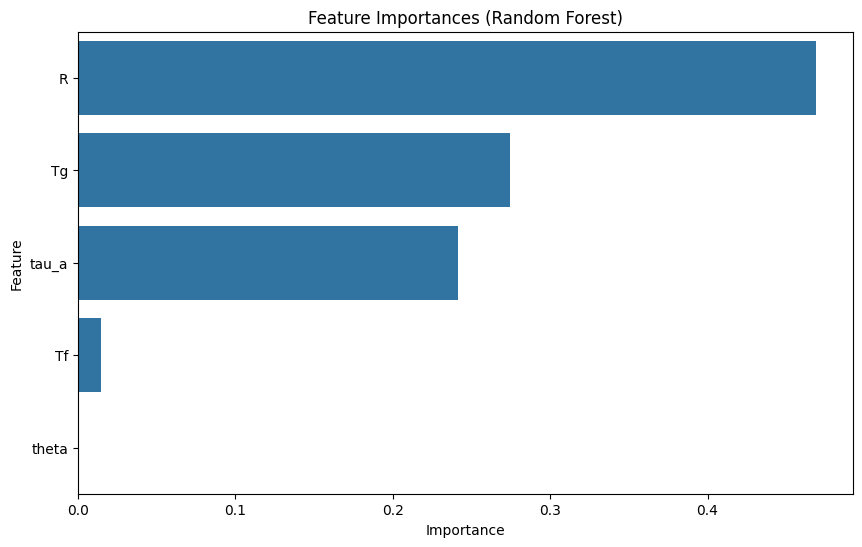

In [23]:
# Get feature importances
feature_importances = rf_model.feature_importances_
features = X_train.columns

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values('Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances (Random Forest)')
plt.show()

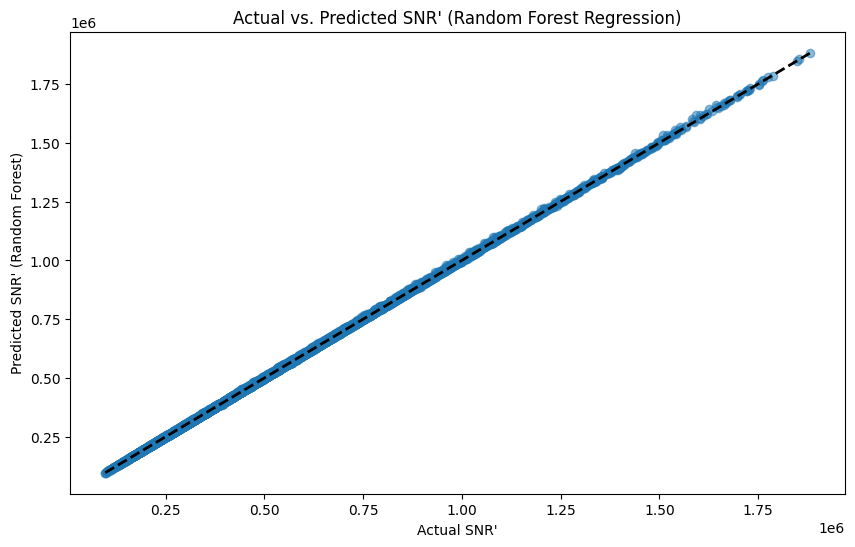

In [24]:
# Plot actual vs predicted values for Random Forest
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual SNR'")
plt.ylabel("Predicted SNR' (Random Forest)")
plt.title("Actual vs. Predicted SNR' (Random Forest Regression)")
plt.show()

In [25]:
# Perform cross-validation
# cv=5 means 5-fold cross-validation
# scoring='neg_mean_squared_error' is commonly used for regression;
# we take the negative because cross_val_score maximizes the score
cv_scores_mse = cross_val_score(rf_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')

# Convert negative MSE to positive MSE for interpretability
cv_mse_scores = -cv_scores_mse

# You can also use R-squared as a scoring metric
cv_scores_r2 = cross_val_score(rf_model, X_train_scaled, y_train, cv=5, scoring='r2')

print(f"Cross-validated MSE scores: {cv_mse_scores}")
print(f"Mean Cross-validated MSE: {cv_mse_scores.mean():.2f}")
print(f"Standard Deviation of Cross-validated MSE: {cv_mse_scores.std():.2f}")

print(f"\nCross-validated R2 scores: {cv_scores_r2}")
print(f"Mean Cross-validated R2: {cv_scores_r2.mean():.2f}")
print(f"Standard Deviation of Cross-validated R2: {cv_scores_r2.std():.2f}")


Cross-validated MSE scores: [ 9871192.3988666  10884629.51466526 10215592.48505613 10558752.92195331
  9034070.11179628]
Mean Cross-validated MSE: 10112847.49
Standard Deviation of Cross-validated MSE: 636740.68

Cross-validated R2 scores: [0.99987804 0.99986566 0.99988264 0.99987462 0.99989017]
Mean Cross-validated R2: 1.00
Standard Deviation of Cross-validated R2: 0.00


#Degree 2 Polynominal Regression


Polynomial Regression (Degree 2) Mean Squared Error: 897718481.43
Polynomial Regression (Degree 2) R-squared: 0.99


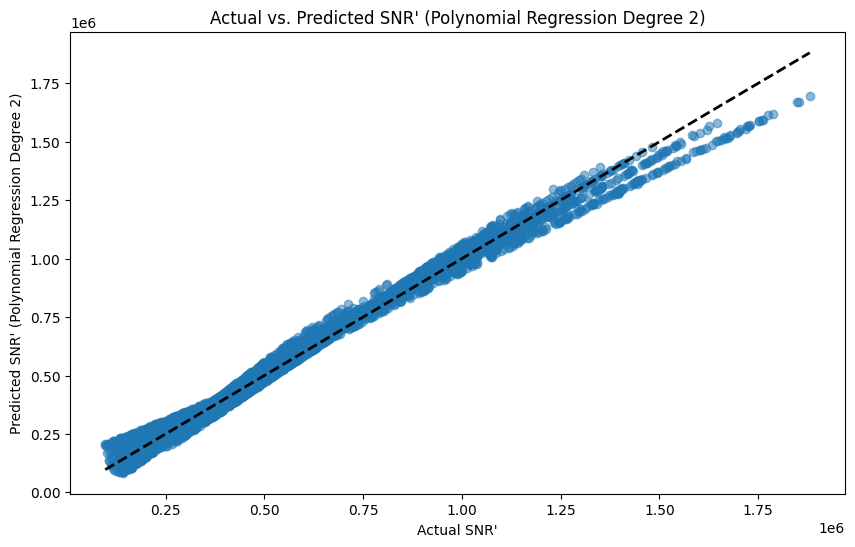

In [26]:
# Create polynomial features. Let's start with degree 2.
degree = 2
poly_features = PolynomialFeatures(degree=degree, include_bias=False)

# Create a pipeline that first transforms features to polynomial and then applies Linear Regression
poly_reg_model = make_pipeline(poly_features, LinearRegression())

# Train the polynomial regression model on the scaled data
# The pipeline handles the feature transformation internally
poly_reg_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_poly = poly_reg_model.predict(X_test_scaled)

# Evaluate the model
mse_poly = mean_squared_error(y_test, y_pred_poly)
r2_poly = r2_score(y_test, y_pred_poly)

print(f"\nPolynomial Regression (Degree {degree}) Mean Squared Error: {mse_poly:.2f}")
print(f"Polynomial Regression (Degree {degree}) R-squared: {r2_poly:.2f}")

# Plot actual vs predicted values for Polynomial Regression
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_poly, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual SNR'")
plt.ylabel(f"Predicted SNR' (Polynomial Regression Degree {degree})")
plt.title(f"Actual vs. Predicted SNR' (Polynomial Regression Degree {degree})")
plt.show()


In [27]:
# Perform cross-validation for Polynomial Regression
cv_scores_mse_poly = cross_val_score(poly_reg_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
cv_mse_scores_poly = -cv_scores_mse_poly

cv_scores_r2_poly = cross_val_score(poly_reg_model, X_train_scaled, y_train, cv=5, scoring='r2')

print(f"\nPolynomial Regression (Degree {degree}) Cross-validated MSE scores: {cv_mse_scores_poly}")
print(f"Polynomial Regression (Degree {degree}) Mean Cross-validated MSE: {cv_mse_scores_poly.mean():.2f}")
print(f"Polynomial Regression (Degree {degree}) Standard Deviation of Cross-validated MSE: {cv_mse_scores_poly.std():.2f}")

print(f"\nPolynomial Regression (Degree {degree}) Cross-validated R2 scores: {cv_scores_r2_poly}")
print(f"Polynomial Regression (Degree {degree}) Mean Cross-validated R2: {cv_scores_r2_poly.mean():.2f}")
print(f"Polynomial Regression (Degree {degree}) Standard Deviation of Cross-validated R2: {cv_scores_r2_poly.std():.2f}")


Polynomial Regression (Degree 2) Cross-validated MSE scores: [9.10803064e+08 9.40345617e+08 1.02288155e+09 9.80641451e+08
 9.61802624e+08]
Polynomial Regression (Degree 2) Mean Cross-validated MSE: 963294861.42
Polynomial Regression (Degree 2) Standard Deviation of Cross-validated MSE: 37777668.30

Polynomial Regression (Degree 2) Cross-validated R2 scores: [0.98874656 0.98839378 0.98824864 0.98835532 0.98830695]
Polynomial Regression (Degree 2) Mean Cross-validated R2: 0.99
Polynomial Regression (Degree 2) Standard Deviation of Cross-validated R2: 0.00


#Degree 3 Polynominal Regression


Polynomial Regression (Degree 3) Mean Squared Error: 80279857.93
Polynomial Regression (Degree 3) R-squared: 1.00


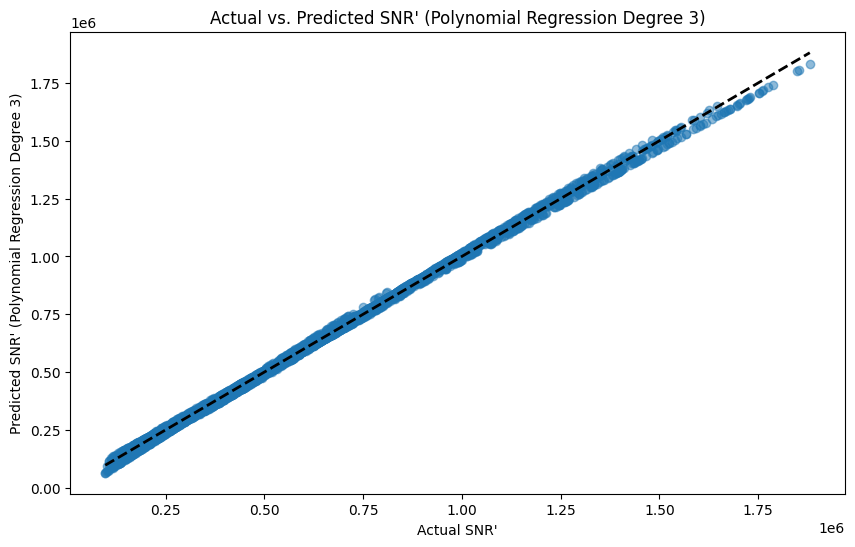


Polynomial Regression (Degree 3) Cross-validated MSE scores: [78721318.04385296 83477763.7484972  88915077.52834022 85285647.1457078
 83243369.9996417 ]
Polynomial Regression (Degree 3) Mean Cross-validated MSE: 83928635.29
Polynomial Regression (Degree 3) Standard Deviation of Cross-validated MSE: 3301366.81

Polynomial Regression (Degree 3) Cross-validated R2 scores: [0.99902736 0.99896968 0.9989785  0.99898727 0.99898797]
Polynomial Regression (Degree 3) Mean Cross-validated R2: 1.00
Polynomial Regression (Degree 3) Standard Deviation of Cross-validated R2: 0.00


In [28]:
# prompt: i want to apply degree 3 polynominal regression

import matplotlib.pyplot as plt
# #Polynominal Regression
# Create polynomial features. Let's set the degree to 3.
degree = 3
poly_features = PolynomialFeatures(degree=degree, include_bias=False)

# Create a pipeline that first transforms features to polynomial and then applies Linear Regression
poly_reg_model = make_pipeline(poly_features, LinearRegression())

# Train the polynomial regression model on the scaled data
# The pipeline handles the feature transformation internally
poly_reg_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_poly = poly_reg_model.predict(X_test_scaled)

# Evaluate the model
mse_poly = mean_squared_error(y_test, y_pred_poly)
r2_poly = r2_score(y_test, y_pred_poly)

print(f"\nPolynomial Regression (Degree {degree}) Mean Squared Error: {mse_poly:.2f}")
print(f"Polynomial Regression (Degree {degree}) R-squared: {r2_poly:.2f}")

# Plot actual vs predicted values for Polynomial Regression
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_poly, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual SNR'")
plt.ylabel(f"Predicted SNR' (Polynomial Regression Degree {degree})")
plt.title(f"Actual vs. Predicted SNR' (Polynomial Regression Degree {degree})")
plt.show()

# #Cross-Validation
# Perform cross-validation for Polynomial Regression
cv_scores_mse_poly = cross_val_score(poly_reg_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
cv_mse_scores_poly = -cv_scores_mse_poly

cv_scores_r2_poly = cross_val_score(poly_reg_model, X_train_scaled, y_train, cv=5, scoring='r2')

print(f"\nPolynomial Regression (Degree {degree}) Cross-validated MSE scores: {cv_mse_scores_poly}")
print(f"Polynomial Regression (Degree {degree}) Mean Cross-validated MSE: {cv_mse_scores_poly.mean():.2f}")
print(f"Polynomial Regression (Degree {degree}) Standard Deviation of Cross-validated MSE: {cv_mse_scores_poly.std():.2f}")

print(f"\nPolynomial Regression (Degree {degree}) Cross-validated R2 scores: {cv_scores_r2_poly}")
print(f"Polynomial Regression (Degree {degree}) Mean Cross-validated R2: {cv_scores_r2_poly.mean():.2f}")
print(f"Polynomial Regression (Degree {degree}) Standard Deviation of Cross-validated R2: {cv_scores_r2_poly.std():.2f}")
